# Projeto

## Data Transformation

-> Aggregation -> Scaling -> Smoothing -> Differentiation -> train-test split

1. Quarter-Hourly
2. Hourly
3. 4-Hourly

In [1]:
import pandas as pd
import numpy as np
import dslabs_functions as dslabs
from matplotlib.pyplot import figure, show, subplots, plot, legend, savefig
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from sklearn.linear_model import LinearRegression
from sklearn.base import RegressorMixin


In [2]:
### Plotting UNIVARIATE Time Series
file_tag = "traffic"
target = "Total"
index="Timestamp"
### ordenar dados no csv ou nao e preciso??? last timestamp esta mal pq dados no csv nao estao ordenados por data
original_data: pd.DataFrame = pd.read_csv(
    "forecast_traffic_single.csv",
    index_col="Timestamp",
    sep=",",
    decimal=".",
    parse_dates=True,
    #infer_datetime_format=True,
)

print(original_data.columns)

### Sort 'TimeStamp' Ascending
original_data.sort_index(inplace=True)
#original_data.index = pd.to_datetime(original_data.index)
original_data.to_csv("sorted_forecast_traffic.csv")
series: pd.Series = original_data[target]
data = original_data.copy()
# Output the inferred frequency
inferred_freq = pd.infer_freq(series.index)
print("Inferred frequency of the DateTimeIndex: ", inferred_freq)

print("Nr. Records = ", series.shape[0])
print("First timestamp", series.index[0])
print("Last timestamp", series.index[-1])

# Aggregations

### Group by hour
ss_grouped_hour = dslabs.ts_aggregation_by(series, "H", "sum")
print("-----")
print(ss_grouped_hour.size)

### Group by 4-hour
grouped_sum_4 = []
indices = []
for j in range(0, len(original_data), 16):
    sum_value_4 = original_data.iloc[j:j+16]['Total'].sum()
    grouped_sum_4.append(sum_value_4)
    indices.append(original_data.index[j])
ss_grouped_4 = pd.Series(grouped_sum_4, index=indices)
print("-----")
print(ss_grouped_4.size)

### Group by 8-hour
grouped_sum_8 = []
indices = []
for j in range(0, len(original_data), 32):
    sum_value_8 = original_data.iloc[j:j+32]['Total'].sum()
    grouped_sum_8.append(sum_value_8)
    indices.append(original_data.index[j])
ss_grouped_8 = pd.Series(grouped_sum_8, index=indices)
print("-----")
print(ss_grouped_8.size)

### Group by Day and Week
ss_days = dslabs.ts_aggregation_by(series, "D", "sum")
print("-----")
print(ss_days.size)
ss_weeks = dslabs.ts_aggregation_by(series, "W", "sum")
print("-----")
print(ss_weeks.size)

Index(['Total'], dtype='object')
Inferred frequency of the DateTimeIndex:  15T
Nr. Records =  2976
First timestamp 2023-10-01 00:00:00
Last timestamp 2023-10-31 23:45:00
-----
744
-----
186
-----
93
-----
31
-----
6


## Aggregation

(2976, 1)
{'RMSE': [60.42407053527841, 57.947297688150634], 'MAE': [51.85260331831049, 49.35545887723025]} {'MAPE': [0.7143747094048871, 0.6947851019902733], 'R2': [5.273998601174057e-07, -0.001306433091169401]}


<Axes: xlabel='Timestamp', ylabel='Total'>

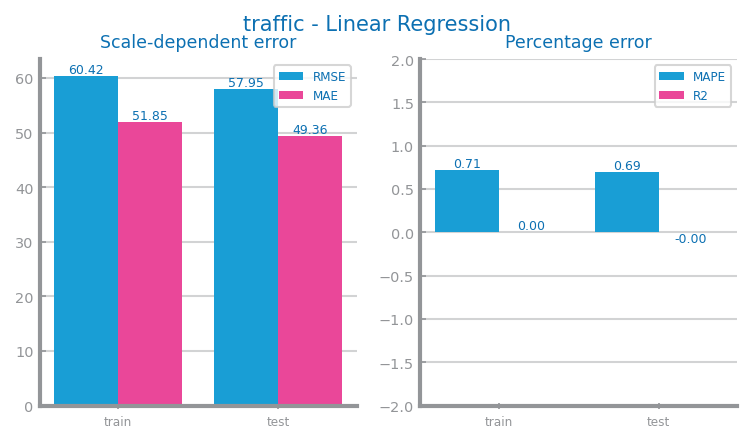

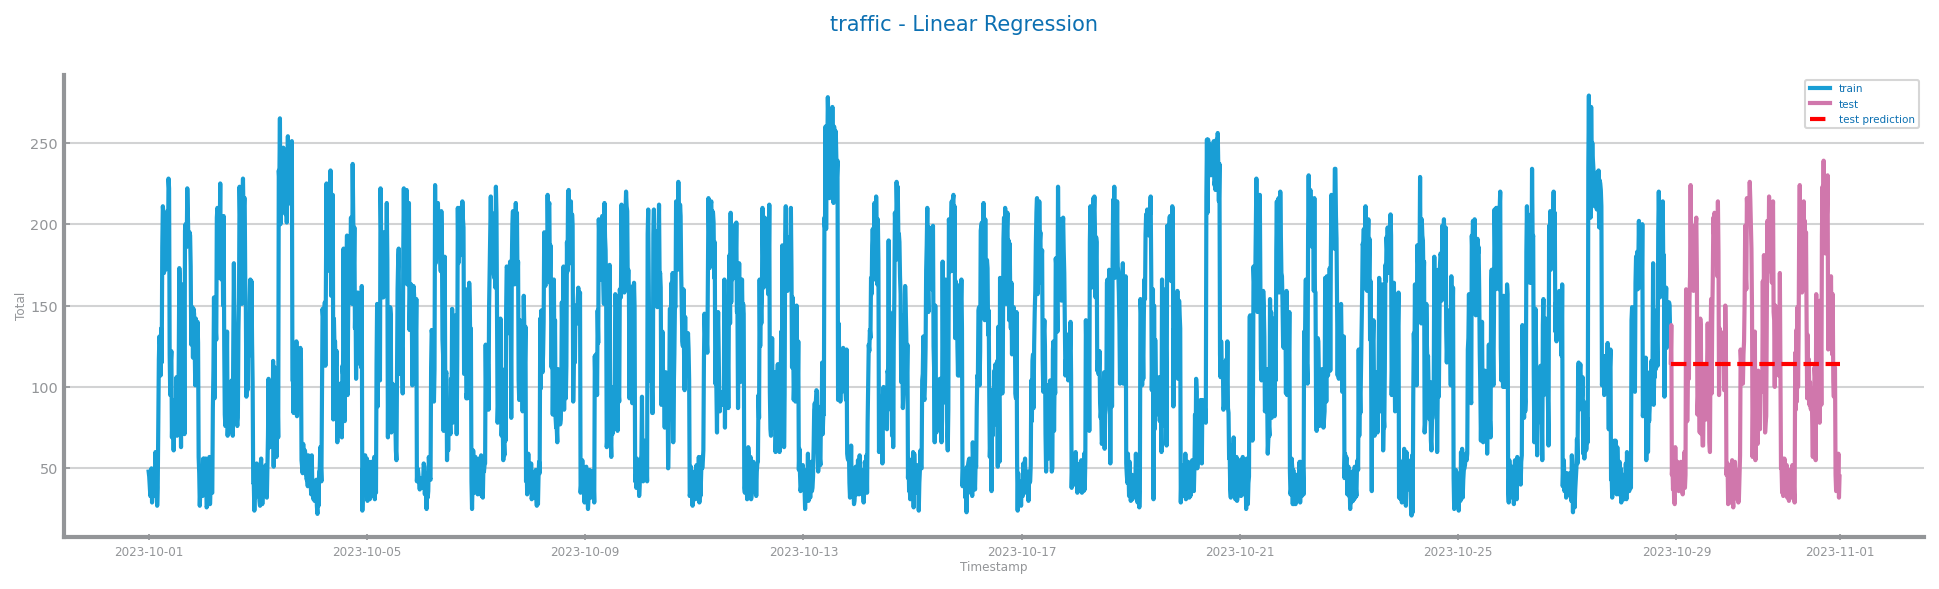

In [3]:
### Plot and Results for Atomic Granularity (15Min)

train_1, test_1 = dslabs.series_train_test_split(original_data, trn_pct=0.90)
print(original_data.shape)
trnX_1 = np.arange(len(train_1)).reshape(-1, 1)
trnY_1 = train_1.to_numpy()

tstX_1 = np.arange(len(train_1), len(original_data)).reshape(-1, 1)
tstY_1 = test_1.to_numpy()

model = LinearRegression()
model.fit(trnX_1, trnY_1)

prd_trn: pd.Series = pd.Series(model.predict(trnX_1), index=train_1.index)
prd_tst: pd.Series = pd.Series(model.predict(tstX_1), index=test_1.index)

dslabs.plot_forecasting_eval(train_1, test_1, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression")

dslabs.plot_forecasting_series(
    train_1,
    test_1,
    prd_tst,
    title=f"{file_tag} - Linear Regression",
    xlabel="Timestamp",
    ylabel=target,
)

(744,)
{'RMSE': [225.29867835364456, 216.48282682677467], 'MAE': [188.1919883155807, 177.69835026900884]} {'MAPE': [0.6273590078749915, 0.602521029563812], 'R2': [1.8993057261385005e-06, -0.0011491329634656378]}


<Axes: xlabel='Timestamp', ylabel='Total'>

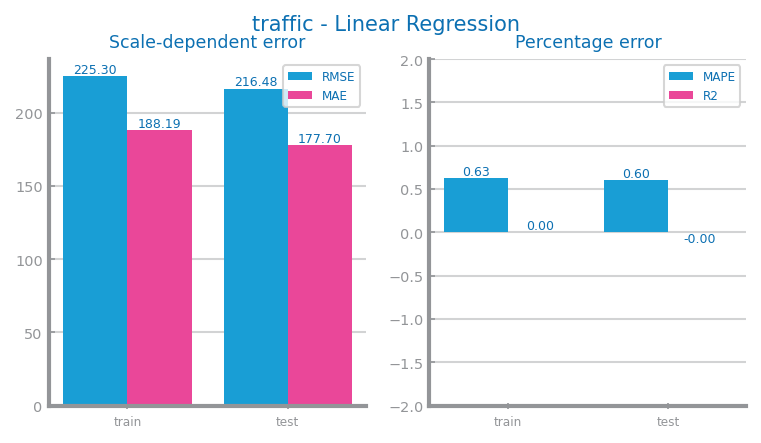

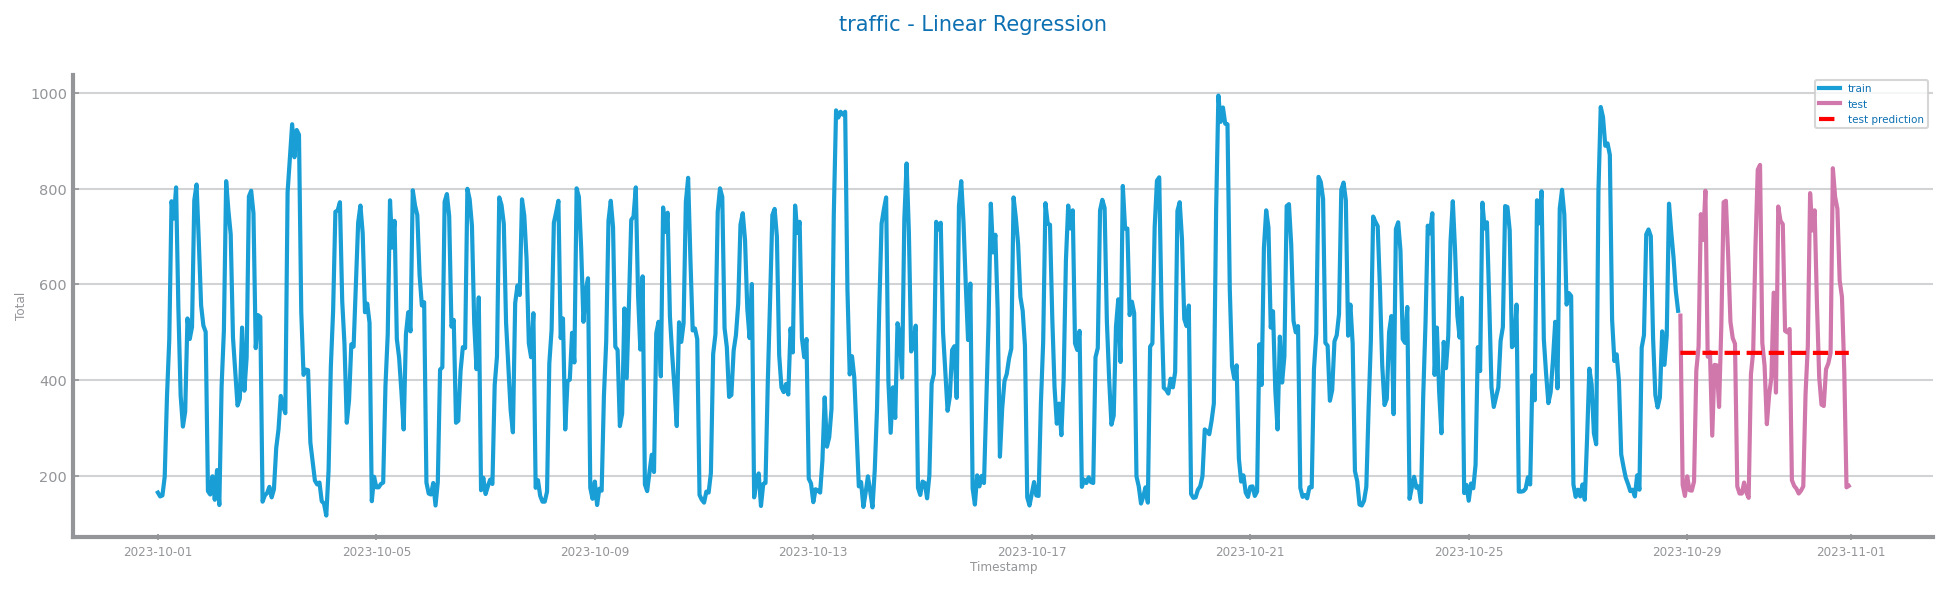

In [4]:
### Plot and Results for 2st Granularity (1Hour)

train_2, test_2 = dslabs.dataframe_temporal_train_test_split(ss_grouped_hour, trn_pct=0.90)
print(ss_grouped_hour.shape)
trnX_2 = np.arange(len(train_2)).reshape(-1, 1)
trnY_2 = train_2.to_numpy()

tstX_2 = np.arange(len(train_2), len(ss_grouped_hour)).reshape(-1, 1)
tstY_2 = test_2.to_numpy()

model = LinearRegression()
model.fit(trnX_2, trnY_2)

prd_trn_2: pd.Series = pd.Series(model.predict(trnX_2), index=train_2.index)
prd_tst_2: pd.Series = pd.Series(model.predict(tstX_2), index=test_2.index)

dslabs.plot_forecasting_eval(train_2, test_2, prd_trn_2, prd_tst_2, title=f"{file_tag} - Linear Regression")

dslabs.plot_forecasting_series(
    train_2,
    test_2,
    prd_tst_2,
    title=f"{file_tag} - Linear Regression",
    xlabel="Timestamp",
    ylabel=target,
)

{'RMSE': [741.0352070247814, 678.4024178051691], 'MAE': [617.5990720281637, 569.6981626926417]} {'MAPE': [0.49520399873861465, 0.44988922256463937], 'R2': [4.537385633329727e-06, -0.0012001798360998794]}


<Axes: xlabel='Timestamp', ylabel='Total'>

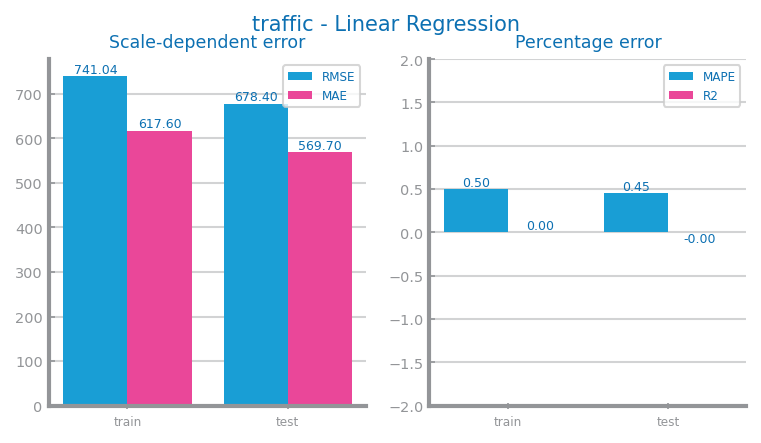

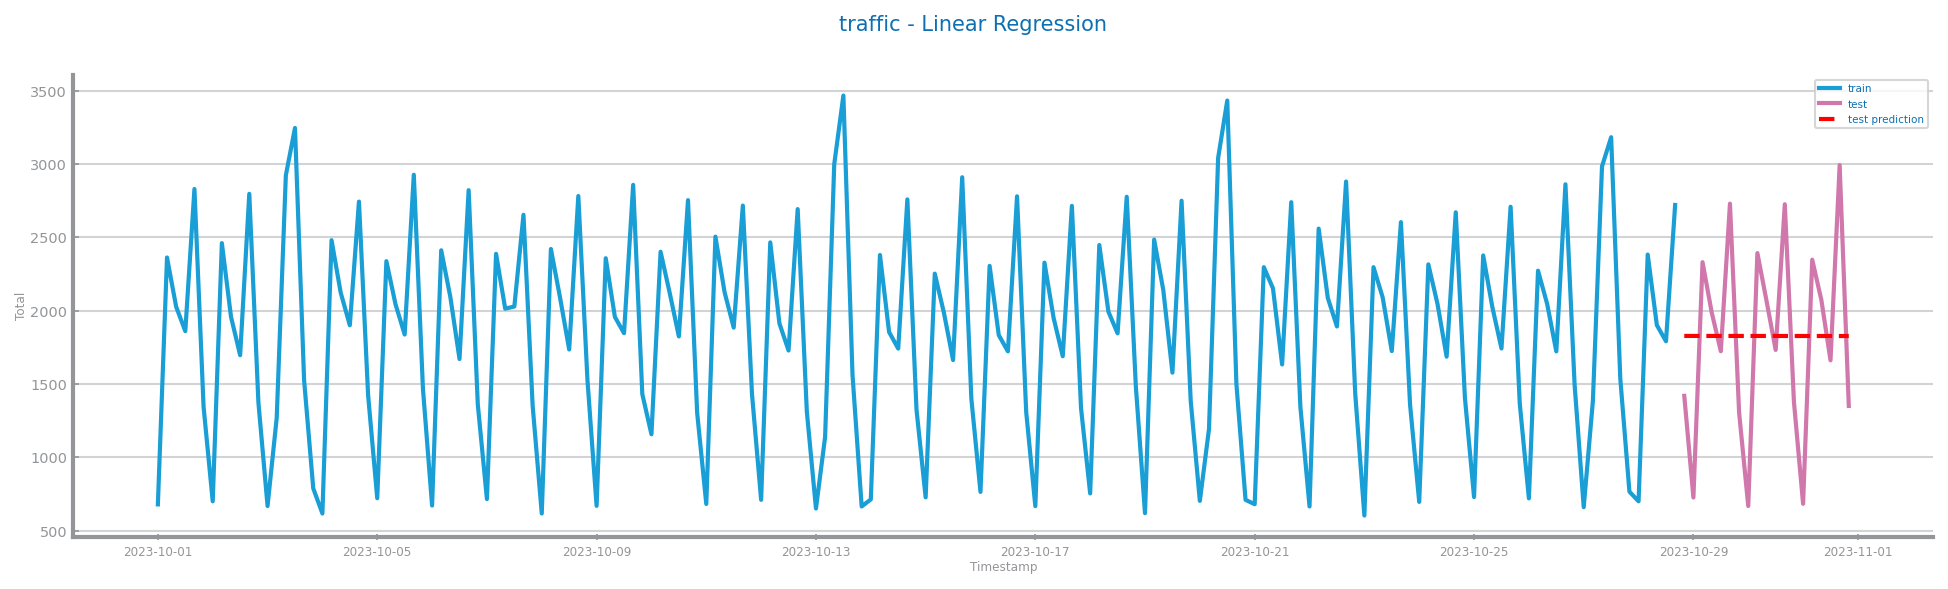

In [5]:
### Plot and Results for 3st Granularity (4Hour)

train_3, test_3 = dslabs.dataframe_temporal_train_test_split(ss_grouped_4, trn_pct=0.90)
trnX_3 = np.arange(len(train_3)).reshape(-1, 1)
trnY_3 = train_3.to_numpy()

tstX_3 = np.arange(len(train_3), len(ss_grouped_4)).reshape(-1, 1)
tstY_3 = test_3.to_numpy()

model = LinearRegression()
model.fit(trnX_3, trnY_3)

prd_trn_3: pd.Series = pd.Series(model.predict(trnX_3), index=train_3.index)
prd_tst_3: pd.Series = pd.Series(model.predict(tstX_3), index=test_3.index)

dslabs.plot_forecasting_eval(train_3, test_3, prd_trn_3, prd_tst_3, title=f"{file_tag} - Linear Regression")

dslabs.plot_forecasting_series(
    train_3,
    test_3,
    prd_tst_3,
    title=f"{file_tag} - Linear Regression",
    xlabel="Timestamp",
    ylabel=target,
)

## Smoothing
1. Atomic Granularity wins

3
7
15
31


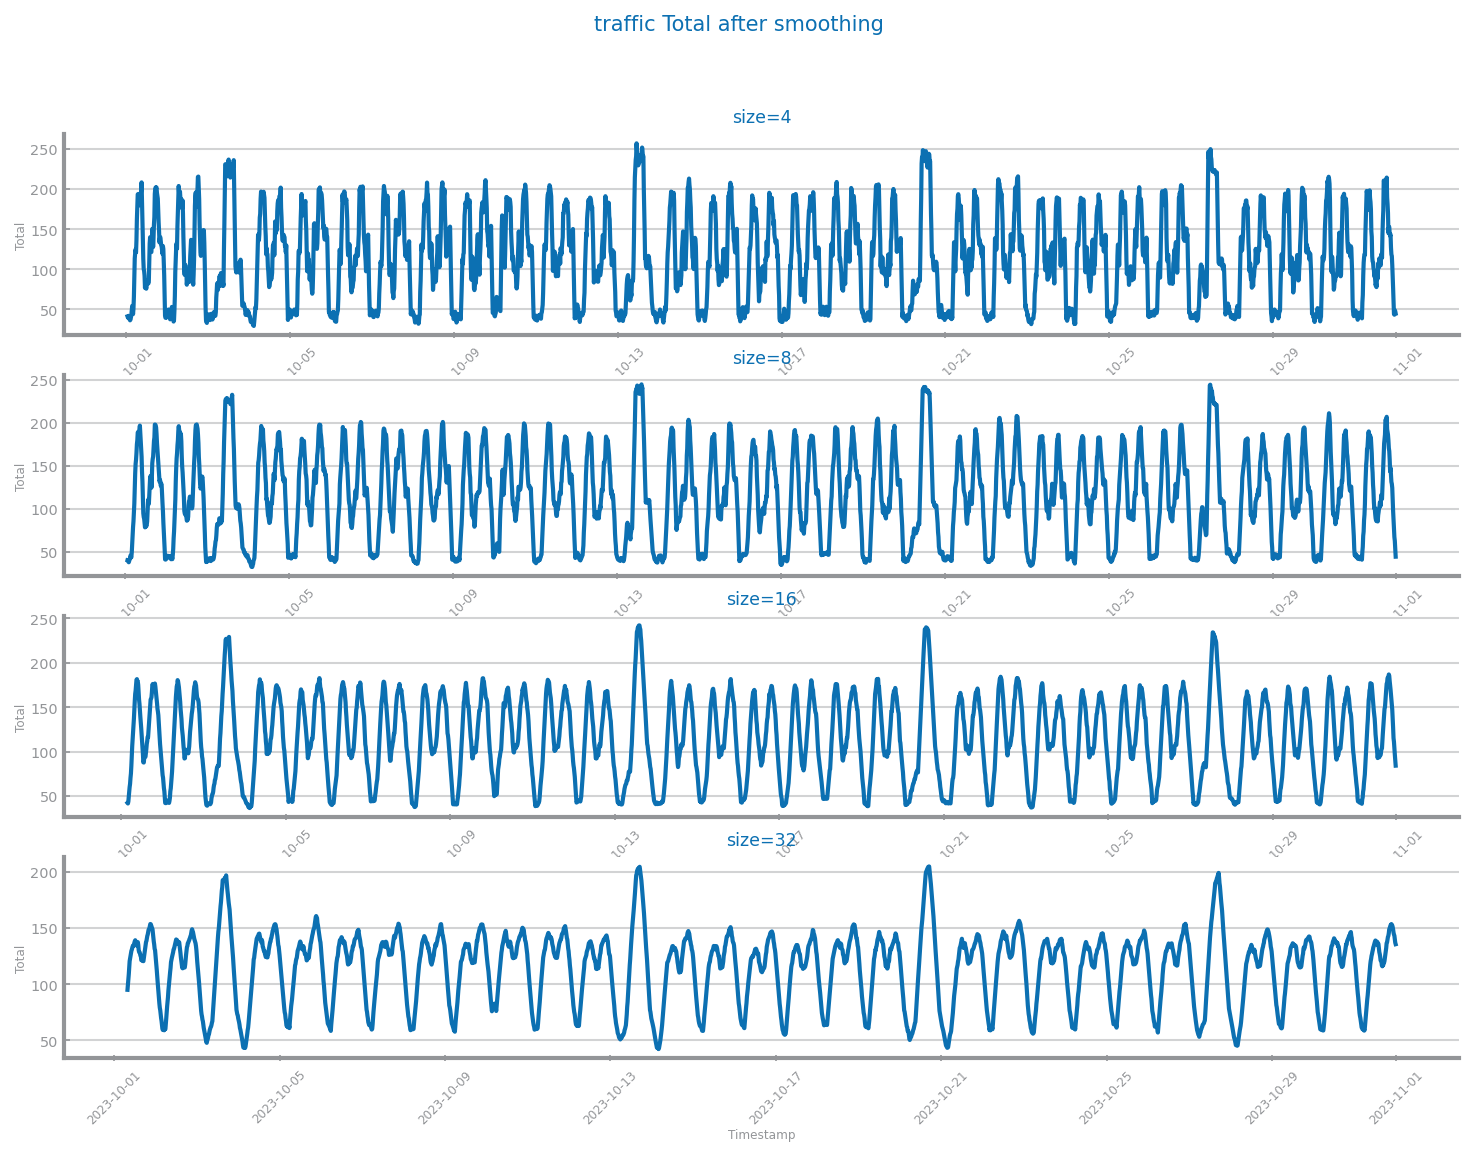

In [3]:
# ## maior window, maior numero de nulos
# # usar mvimputation como na classificacao/ considerar retirar
# sizes: list[int] = [4, 8, 16, 32]
# fig: Figure
# axs: list[Axes]
# fig, axs = subplots(len(sizes), 1, figsize=(3 * dslabs.HEIGHT, dslabs.HEIGHT / 2 * len(sizes)))
# fig.suptitle(f"{file_tag} {target} after smoothing")

# for i in range(len(sizes)):
#     ss_smooth: pd.Series = series.rolling(window=sizes[i]).mean()
#     ##ss_smooth.fillna(method='ffill', inplace=True)
#     null_count = ss_smooth.isnull().sum()
#     print(null_count)
#     dslabs.plot_line_chart(
#         ss_smooth.index.to_list(),
#         ss_smooth.to_list(),
#         ax=axs[i],
#         xlabel=ss_smooth.index.name,
#         ylabel=target,
#         title=f"size={sizes[i]}",
#     )
# show()

(2678, 1)
{'RMSE': [60.42407053527841, 57.947297688150634], 'MAE': [51.85260331831049, 49.35545887723025]} {'MAPE': [0.7143747094048871, 0.6947851019902733], 'R2': [5.273998601174057e-07, -0.001306433091169401]}


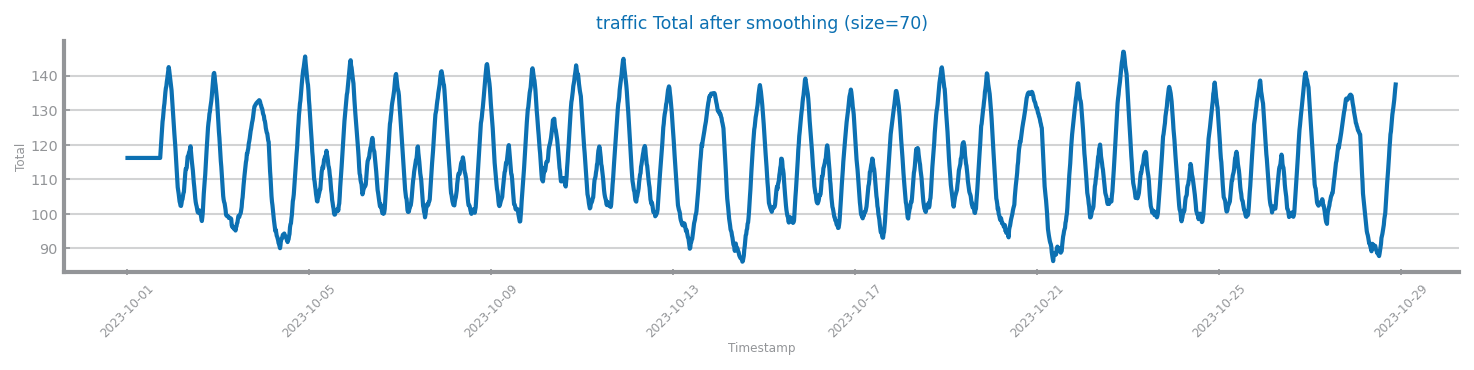

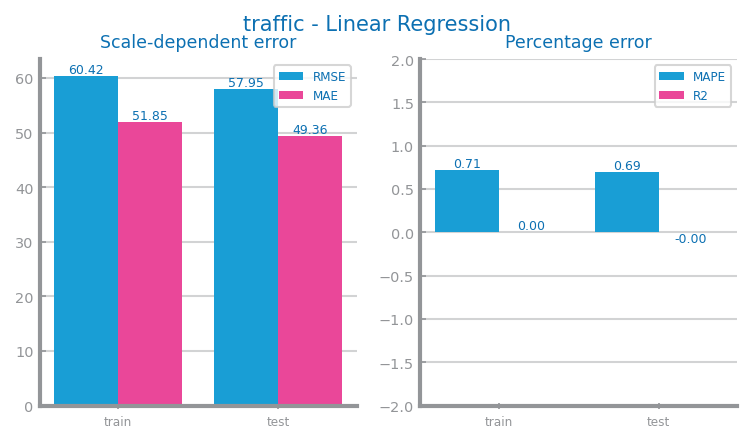

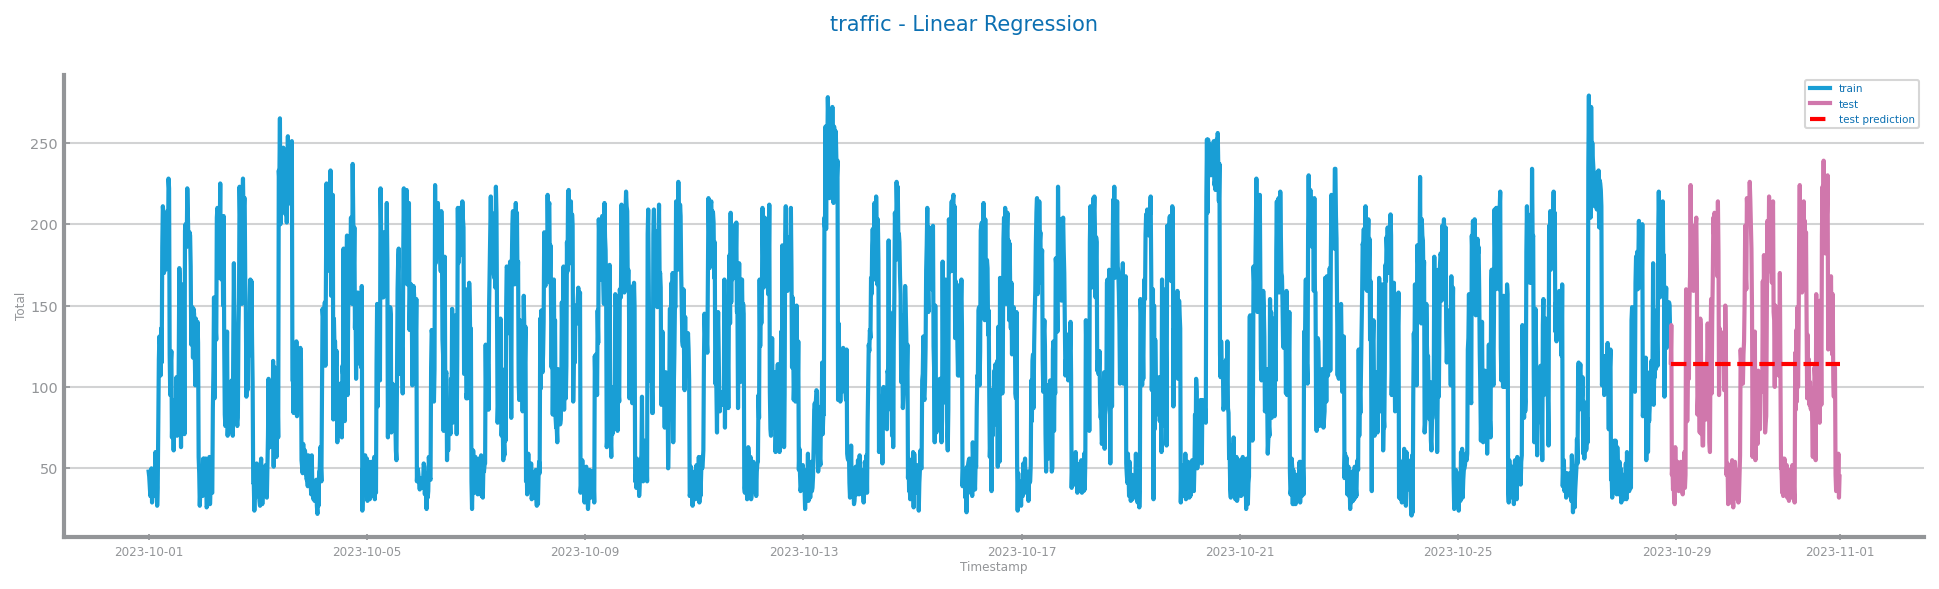

In [8]:
# ## se usei funcao de soma para agregacao aqui uso media na mesma?
# WIN_SIZE = 70

# train_1, test_1 = dslabs.dataframe_temporal_train_test_split(original_data, trn_pct=0.90)

# series_only_train: pd.Series = train_1[target]
# series_only_train: pd.DataFrame = series_only_train.rolling(window=WIN_SIZE).mean()
# series_only_train.bfill(inplace=True)

# figure(figsize=(3 * dslabs.HEIGHT, dslabs.HEIGHT / 2))
# dslabs.plot_line_chart(
#     series_only_train.index.to_list(),
#     series_only_train.to_list(),
#     xlabel=series_only_train.index.name,
#     ylabel=target,
#     title=f"{file_tag} {target} after smoothing (size={WIN_SIZE})",
# )

# trnX_smooth = np.arange(len(train_1)).reshape(-1, 1)
# trnY_smooth = train_1.to_numpy().ravel()

# tstX_smooth = np.arange(len(train_1), len(original_data)).reshape(-1, 1)
# tstY_smooth = test_1.to_numpy().ravel()

# model = LinearRegression()
# model.fit(trnX_smooth, trnY_smooth)

# print(trnX_smooth.shape)
# prd_trn_smooth: pd.Series = pd.Series(model.predict(trnX_smooth), index=train_1.index)
# prd_tst_smooth: pd.Series = pd.Series(model.predict(tstX_smooth), index=test_1.index)

# dslabs.plot_forecasting_eval(train_1, test_1, prd_trn_smooth, prd_tst_smooth, title=f"{file_tag} - Linear Regression")

# dslabs.plot_forecasting_series(
#     train_1,
#     test_1,
#     prd_tst_smooth,
#     title=f"{file_tag} - Linear Regression",
#     xlabel="Timestamp",
#     ylabel=target,
# )
# show()

(2976,)
{'RMSE': [47.12029104115679, 42.785329003039884], 'MAE': [40.01937782088901, 36.61806820006142]} {'MAPE': [0.4939572467173969, 0.44165362101334676], 'R2': [1.2235323241460705e-05, 0.00016422844653429802]}


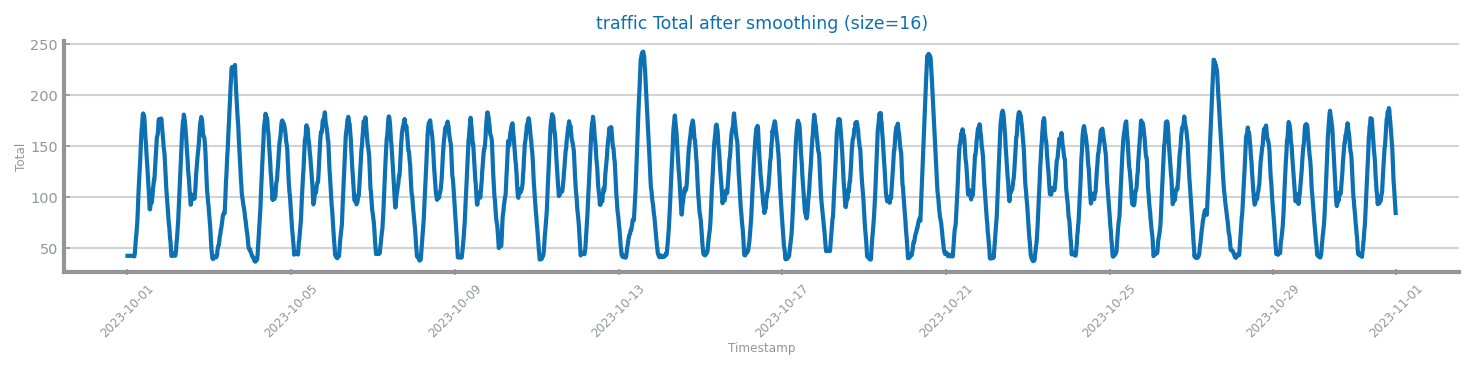

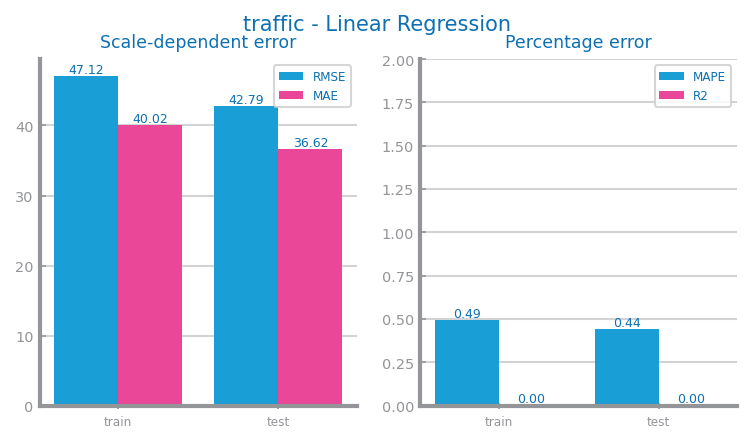

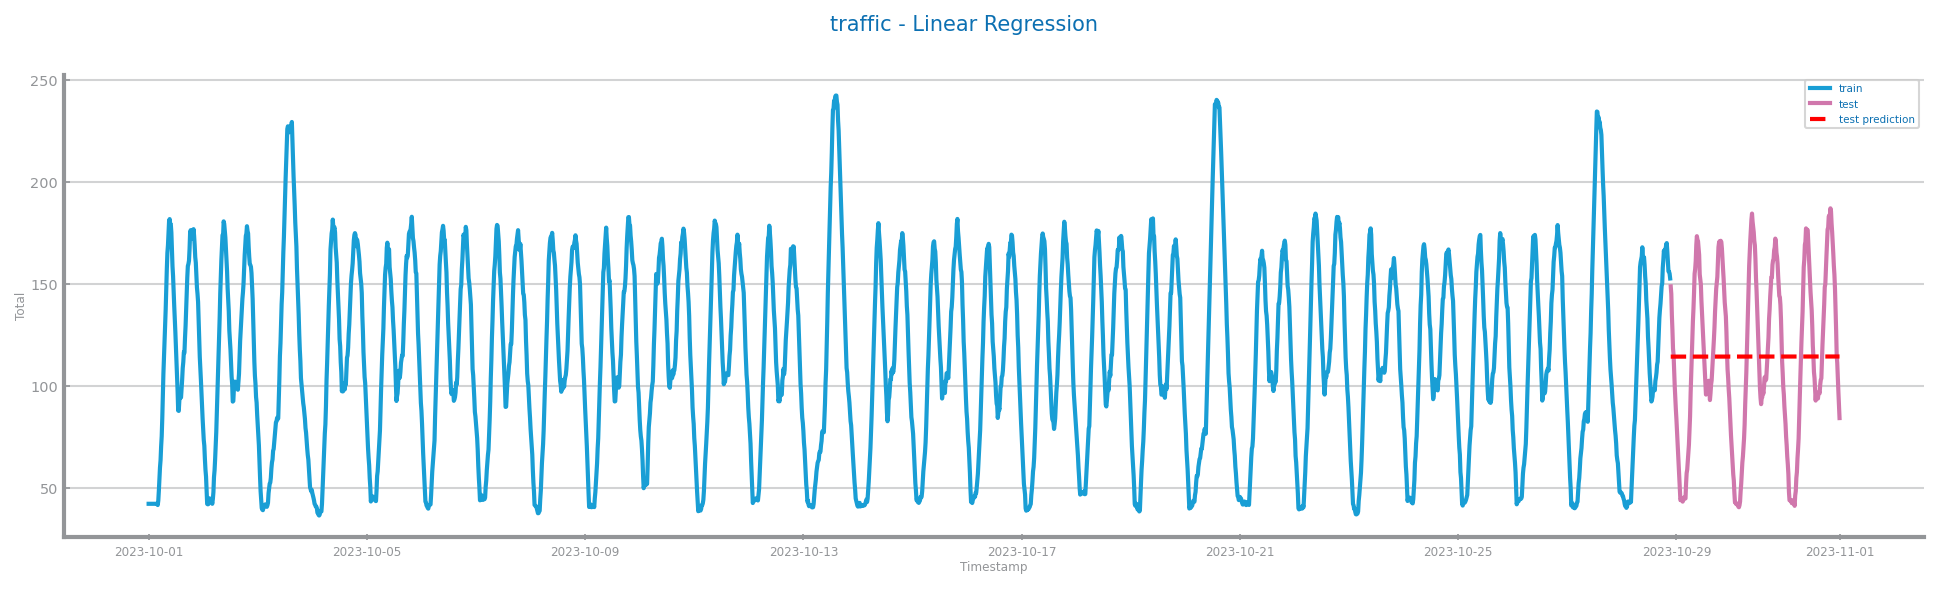

In [19]:
## se usei funcao de soma para agregacao aqui uso media na mesma?
WIN_SIZE = 16
print(series.shape)
ss_smooth_atomic: pd.DataFrame = series.rolling(window=WIN_SIZE).mean()
ss_smooth_atomic.bfill(inplace=True)

figure(figsize=(3 * dslabs.HEIGHT, dslabs.HEIGHT / 2))
dslabs.plot_line_chart(
    ss_smooth_atomic.index.to_list(),
    ss_smooth_atomic.to_list(),
    xlabel=ss_smooth_atomic.index.name,
    ylabel=target,
    title=f"{file_tag} {target} after smoothing (size={WIN_SIZE})",
)

train_smooth, test_smooth = dslabs.dataframe_temporal_train_test_split(ss_smooth_atomic, trn_pct=0.90)

trnX_smooth = np.arange(len(train_smooth)).reshape(-1, 1)
trnY_smooth = train_smooth.to_numpy().ravel()

tstX_smooth = np.arange(len(train_smooth), len(ss_smooth_atomic)).reshape(-1, 1)
tstY_smooth = test_smooth.to_numpy().ravel()

model = LinearRegression()
model.fit(trnX_smooth, trnY_smooth)

prd_trn_smooth: pd.Series = pd.Series(model.predict(trnX_smooth), index=train_smooth.index)
prd_tst_smooth: pd.Series = pd.Series(model.predict(tstX_smooth), index=test_smooth.index)

dslabs.plot_forecasting_eval(train_smooth, test_smooth, prd_trn_smooth, prd_tst_smooth, title=f"{file_tag} - Linear Regression")

dslabs.plot_forecasting_series(
    train_smooth,
    test_smooth,
    prd_tst_smooth,
    title=f"{file_tag} - Linear Regression",
    xlabel="Timestamp",
    ylabel=target,
)
show()

## Differentiation
*differentiation serve para transformar uma serie em stacionaria, se a minha ja e faz sentido aplicar?*<br>
*verificar se é estationaria com o teste de dickey fuller navemente?*

(2976,)
ADF Statistic: -10.044
p-value: 0.000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
The series is stationary
{'RMSE': [5.474, 5.591], 'MAE': [4.595, 4.803]} {'MAPE': [2888839254183.7, 53230202313.469], 'R2': [1.53400e-05, -0.00168]}
{'RMSE': [5.4741084393202355, 5.591254655153293], 'MAE': [4.5958381749020925, 4.803456361939438]} {'MAPE': [2888839254183.7944, 53230202313.469185], 'R2': [1.5340098729055285e-05, -0.001689761755673258]}


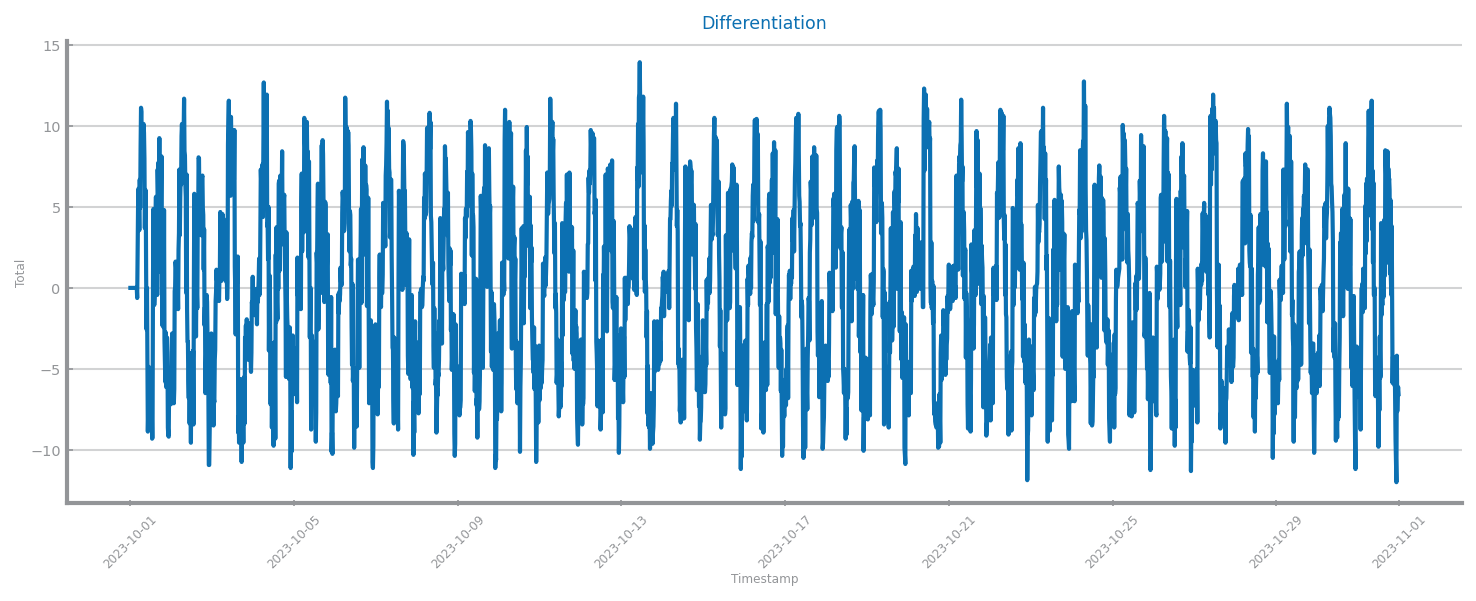

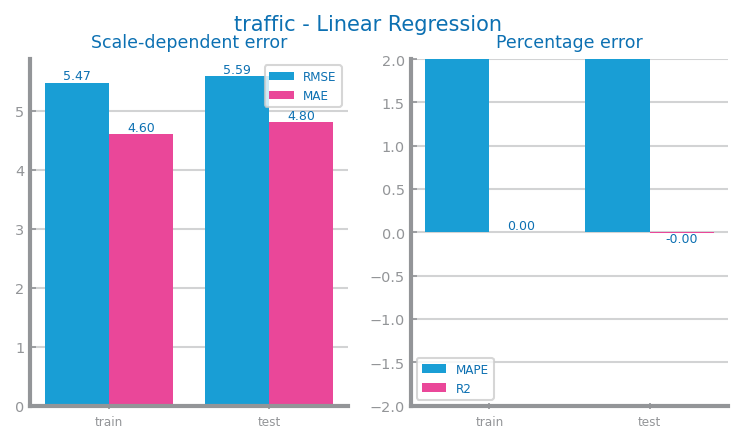

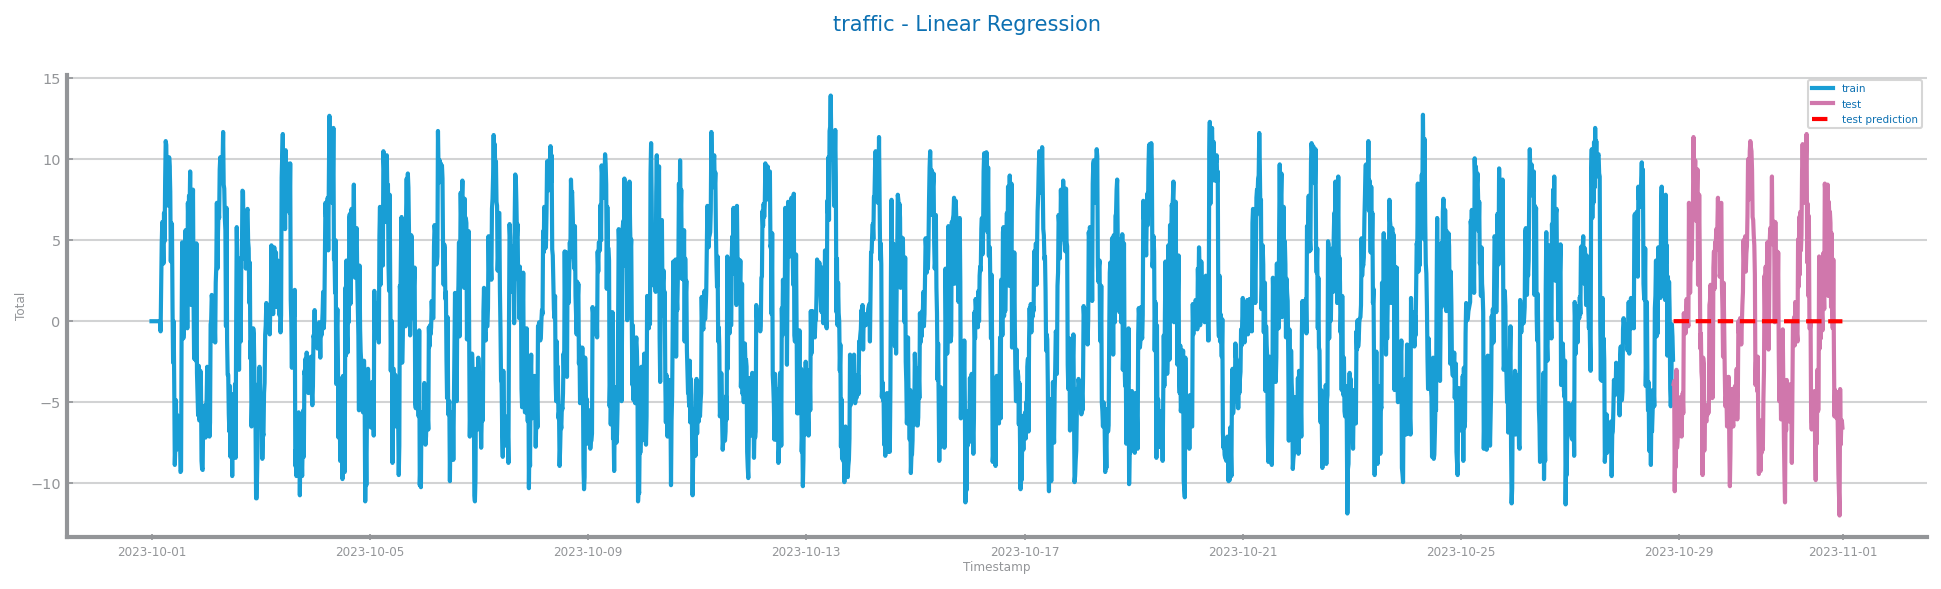

In [16]:
## First Differentiation
ss_diff: pd.Series = ss_smooth_atomic.diff()
ss_diff[0] = 0
print(ss_diff.shape)
print(f"The series {('is' if dslabs.eval_stationarity(series) else 'is not')} stationary")
figure(figsize=(3 * dslabs.HEIGHT, dslabs.HEIGHT))
dslabs.plot_line_chart(
    ss_diff.index.to_list(),
    ss_diff.to_list(),
    title="Differentiation",
    xlabel=series.index.name,
    ylabel=target,
)

train_diff, test_diff = dslabs.dataframe_temporal_train_test_split(ss_diff, trn_pct=0.90)

trnX_diff = np.arange(len(train_diff)).reshape(-1, 1)
trnY_diff = train_diff.to_numpy().ravel()

tstX_diff = np.arange(len(train_diff), len(ss_diff)).reshape(-1, 1)
tstY_diff = test_diff.to_numpy().ravel()

model = LinearRegression()
model.fit(trnX_diff, trnY_diff)

prd_trn_diff: pd.Series = pd.Series(model.predict(trnX_diff), index=train_diff.index)
prd_tst_diff: pd.Series = pd.Series(model.predict(tstX_diff), index=test_diff.index)
print("{'RMSE': [5.474, 5.591], 'MAE': [4.595, 4.803]} {'MAPE': [2888839254183.7, 53230202313.469], 'R2': [1.53400e-05, -0.00168]}")
dslabs.plot_forecasting_eval(train_diff, test_diff, prd_trn_diff, prd_tst_diff, title=f"{file_tag} - Linear Regression")

dslabs.plot_forecasting_series(
    train_diff,
    test_diff,
    prd_tst_diff,
    title=f"{file_tag} - Linear Regression",
    xlabel="Timestamp",
    ylabel=target,
)
show()

ADF Statistic: -10.044
p-value: 0.000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
The series is stationary
{'RMSE': [3.033, 2.998], 'MAE': [2.267, 2.283]} {'MAPE': [99057114225.309, 357566406282.854], 'R2': [2.74627e-07, -9.4198e-06]}
{'RMSE': [3.0338902244865125, 2.9981520364024297], 'MAE': [2.267335873477463, 2.282518233688258]} {'MAPE': [99057114225.30968, 357566406282.85474], 'R2': [2.7462709506487215e-07, -9.419894699602693e-06]}


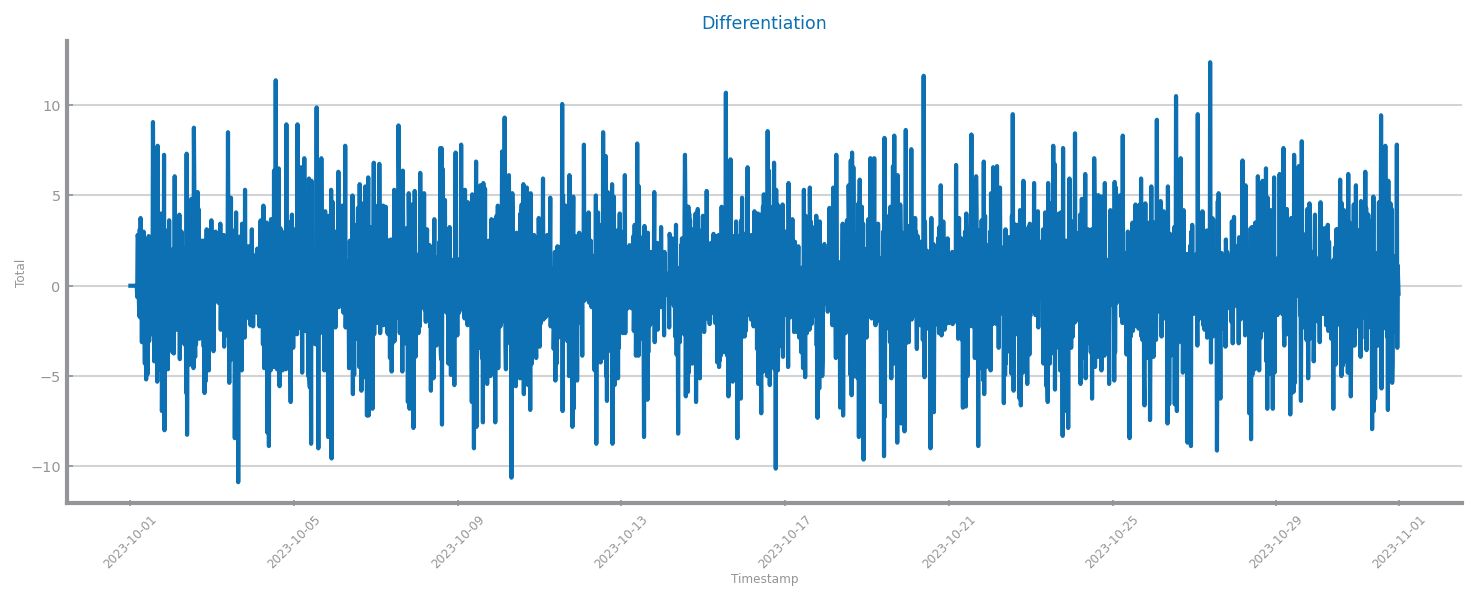

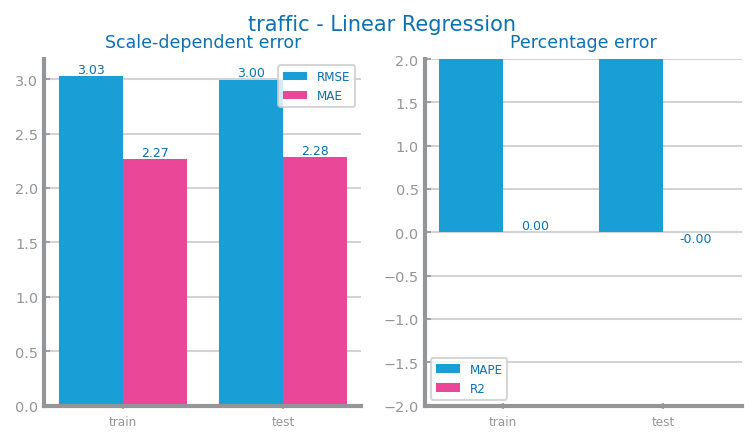

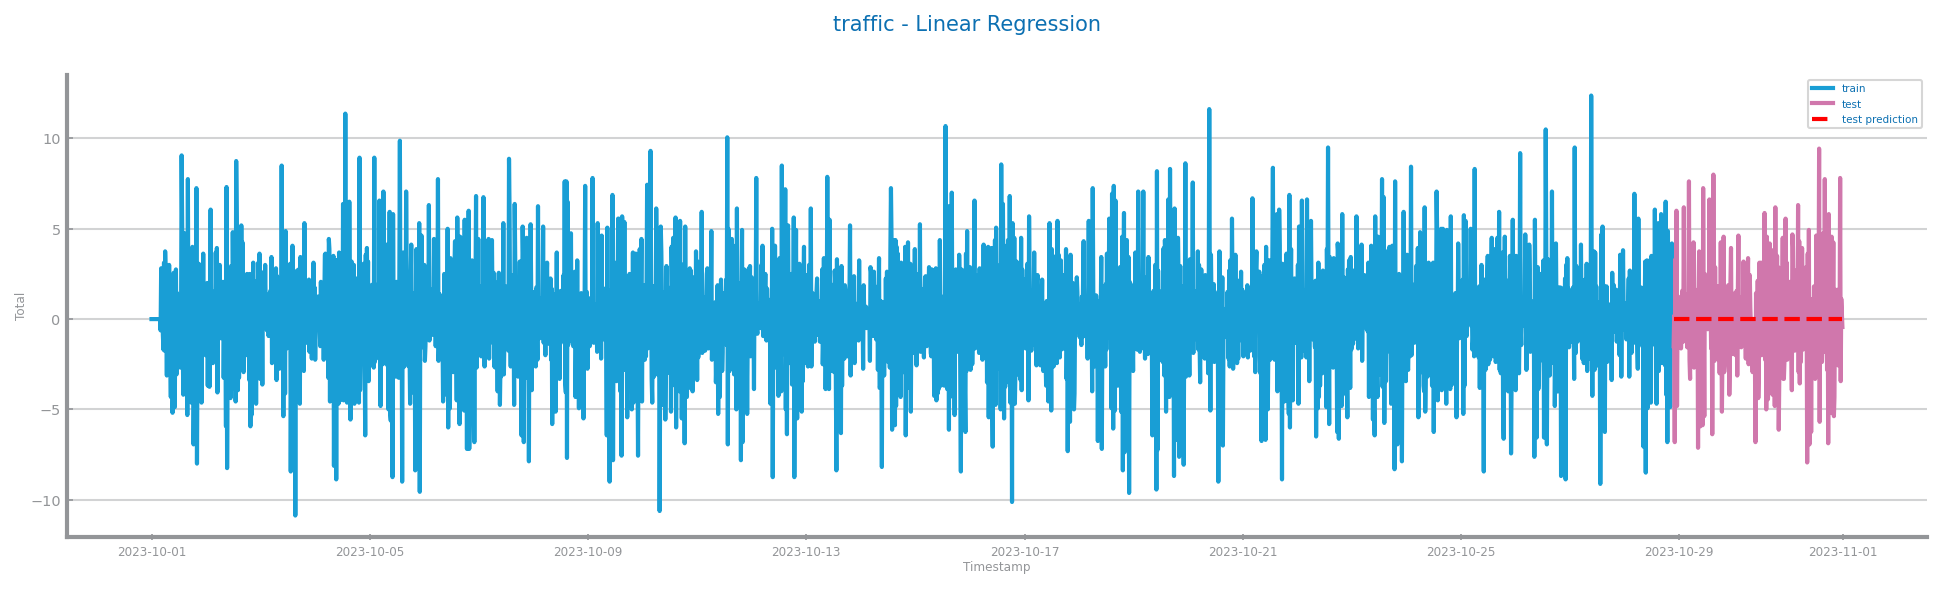

In [17]:
## Second Differentiation
ss_diff_2: pd.Series = ss_diff.diff()
ss_diff_2[0] = 0
figure(figsize=(3 * dslabs.HEIGHT, dslabs.HEIGHT))
print(f"The series {('is' if dslabs.eval_stationarity(series) else 'is not')} stationary")
dslabs.plot_line_chart(
    ss_diff_2.index.to_list(),
    ss_diff_2.to_list(),
    title="Differentiation",
    xlabel=series.index.name,
    ylabel=target,
)

train_diff_2, test_diff_2 = dslabs.dataframe_temporal_train_test_split(ss_diff_2, trn_pct=0.90)

trnX_diff_2 = np.arange(len(train_diff_2)).reshape(-1, 1)
trnY_diff_2 = train_diff_2.to_numpy().ravel()

tstX_diff_2 = np.arange(len(train_diff_2), len(ss_diff_2)).reshape(-1, 1)
tstY_diff_2 = test_diff_2.to_numpy().ravel()

model = LinearRegression()
model.fit(trnX_diff_2, trnY_diff_2)

prd_trn_diff_2: pd.Series = pd.Series(model.predict(trnX_diff_2), index=train_diff_2.index)
prd_tst_diff_2: pd.Series = pd.Series(model.predict(tstX_diff_2), index=test_diff_2.index)
print("{'RMSE': [3.033, 2.998], 'MAE': [2.267, 2.283]} {'MAPE': [99057114225.309, 357566406282.854], 'R2': [2.74627e-07, -9.4198e-06]}")
dslabs.plot_forecasting_eval(train_diff_2, test_diff_2, prd_trn_diff_2, prd_tst_diff_2, title=f"{file_tag} - Linear Regression")

dslabs.plot_forecasting_series(
    train_diff_2,
    test_diff_2,
    prd_tst_diff_2,
    title=f"{file_tag} - Linear Regression",
    xlabel="Timestamp",
    ylabel=target,
)
show()

## Scaling

In [9]:
from sklearn.preprocessing import StandardScaler

def scale_series(series: pd.Series) -> pd.Series:
    series_reshaped = series.values.reshape(-1, 1)
    transf = StandardScaler().fit(series_reshaped)
    scaled_data = transf.transform(series_reshaped)
    scaled_series = pd.Series(scaled_data.flatten(), index=series.index)
    return scaled_series

In [11]:
## teste
df: pd.DataFrame = dslabs.scale_all_dataframe(ss_smooth_atomic)

ss: pd.Series = df[target]
figure(figsize=(3 * dslabs.HEIGHT, dslabs.HEIGHT / 2))
dslabs.plot_line_chart(
    ss.index.to_list(),
    ss.to_list(),
    xlabel=ss.index.name,
    ylabel=target,
    title=f"{file_tag} {target} after scaling",
)

train_scaled_og, test_scaled_og = dslabs.series_train_test_split(ss_smooth_atomic, trn_pct=0.90)
print(ss_smooth_atomic.shape)
trnX_scaled_og = np.arange(len(train_scaled_og)).reshape(-1, 1)
trnY_scaled_og = train_scaled_og.to_numpy()

tstX_scaled_og = np.arange(len(train_scaled_og), len(ss_smooth_atomic)).reshape(-1, 1)
tstY_scaled_og = test_scaled_og.to_numpy()

model = LinearRegression()
model.fit(trnX_scaled_og, trnY_scaled_og)

prd_trn_scaled_og: pd.Series = pd.Series(model.predict(trnX_scaled_og), index=train_scaled_og.index)
prd_tst_scaled_og: pd.Series = pd.Series(model.predict(tstX_scaled_og), index=test_scaled_og.index)

dslabs.plot_forecasting_eval(train_scaled_og, test_scaled_og, prd_trn_scaled_og, prd_tst_scaled_og, title=f"{file_tag} - Linear Regression")

dslabs.plot_forecasting_series(
    train_scaled_og,
    test_scaled_og,
    prd_tst_scaled_og,
    title=f"{file_tag} - Linear Regression",
    xlabel="Timestamp",
    ylabel=target,
)
show()

AttributeError: 'Series' object has no attribute 'columns'

In [ ]:
df: pd.Series = scale_series(ss_diff)
print(df.shape)
print(ss_smooth_atomic.shape)
ss_scaled_series: pd.Series = ss_diff
figure(figsize=(3 * dslabs.HEIGHT, dslabs.HEIGHT / 2))
dslabs.plot_line_chart(
    ss_scaled_series.index.to_list(),
    ss_scaled_series.to_list(),
    xlabel=ss_scaled_series.index.name,
    ylabel=target,
    title=f"{file_tag} {target} after scaling",
)

train_scaled_2, test_scaled_2 = dslabs.dataframe_temporal_train_test_split(ss_scaled_series, trn_pct=0.90)
print(ss_scaled_series.shape)
trnX_scaled_2 = np.arange(len(train_scaled_2)).reshape(-1, 1)
trnY_scaled_2 = train_scaled_2.to_numpy()

tstX_scaled_2 = np.arange(len(train_scaled_2), len(ss_scaled_series)).reshape(-1, 1)
tstY_scaled_2 = test_scaled_2.to_numpy()

model = LinearRegression()
model.fit(trnX_scaled_2, trnY_scaled_2)

prd_trn_scaled_2: pd.Series = pd.Series(model.predict(trnX_scaled_2), index=train_scaled_2.index)
prd_tst_scaled_2: pd.Series = pd.Series(model.predict(tstX_scaled_2), index=test_scaled_2.index)

dslabs.plot_forecasting_eval(train_scaled_2, test_scaled_2, prd_trn_scaled_2, prd_tst_scaled_2, title=f"{file_tag} - Linear Regression")

dslabs.plot_forecasting_series(
    train_scaled_2,
    test_scaled_2,
    prd_tst_scaled_2,
    title=f"{file_tag} - Linear Regression",
    xlabel="Timestamp",
    ylabel=target,
)
show()